## Library Loading

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-30 14:31:46--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M   259KB/s    in 90s     

2022-09-30 14:33:17 (1.25 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

## Data Loading

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
x = data['images']
y = data['labels']
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))

y = y.astype('int32')
x = x.astype('float32') / 255.

# shape
x = x.reshape((-1, resolution, resolution, 1))

Text(0.5, 1.0, 'H')

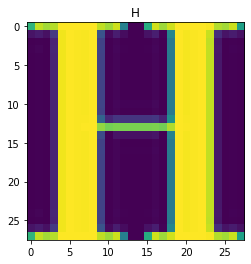

In [4]:
# looking at data
i = np.random.randint(0, 18724)

plt.imshow(x[i, :, :, 0])
plt.title('ABCDEFGHIJ'[y[i]])

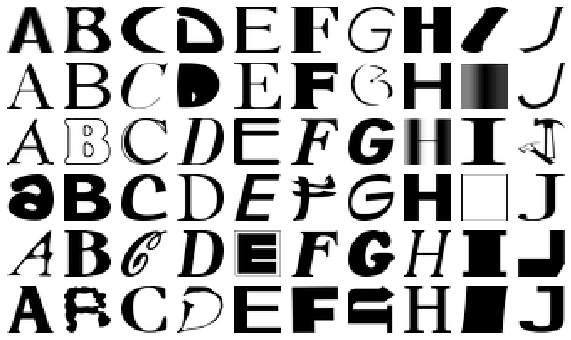

In [5]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
  letters = x[y == letter_id]
  for i in range(rows):
    ax = axs[i, letter_id]
    ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
              cmap='Greys', interpolation='none')
    ax.axis('off')

In [6]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)

In [7]:
# one-hot encoding
class_n = len(set(y_train))

y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

In [8]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

## Keras Modeling

In [9]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout

In [10]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [11]:
mcp = ModelCheckpoint(filepath='./content/model.ckpt',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=True)

In [12]:
## Sequential API ##
# 1. Session Clear
keras.backend.clear_session()

# 2. Model
model = keras.models.Sequential()

# 3. Layer
model.add(keras.layers.Input(shape=(28, 28, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

# 4. Compile
model.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'],
              optimizer=keras.optimizers.Adam())

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              1

In [14]:
# 5. fit
model.fit(x_train, y_train, validation_split=0.2, callbacks=[es, mcp],
          verbose=1, epochs=100)

Epoch 1/100
374/375 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.8457
Epoch 1: val_loss improved from inf to 0.48181, saving model to ./content/model.ckpt
375/375 [==============================] - 6s 5ms/step - loss: 0.6007 - accuracy: 0.8456 - val_loss: 0.4818 - val_accuracy: 0.8738
Epoch 2/100
373/375 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.8927
Epoch 2: val_loss did not improve from 0.48181
375/375 [==============================] - 2s 4ms/step - loss: 0.3749 - accuracy: 0.8927 - val_loss: 0.4886 - val_accuracy: 0.8772
Epoch 3/100
373/375 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.9031
Epoch 3: val_loss improved from 0.48181 to 0.46613, saving model to ./content/model.ckpt
375/375 [==============================] - 2s 5ms/step - loss: 0.3175 - accuracy: 0.9031 - val_loss: 0.4661 - val_accuracy: 0.8818
Epoch 4/100
372/375 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.911

In [15]:
# 6. pred
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(y_train.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(y_test.argmax(axis=1), single_pred_test)

print('트레이닝 정확도 : {:.2f}%'.format(logi_train_accuracy*100))
print('테스트 정확도 : {:.2f}%'.format(logi_test_accuracy*100))

트레이닝 정확도 : 93.18%
테스트 정확도 : 89.80%
